# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


# parameters

In [4]:
# _fname = "../replays/local.log"
_fname = "../replays/log21-faster.log"
_time_step = 100
_max_time = 200000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]

print("_fname", _fname)


_fname ../replays/log21-faster.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__game_state_start", end_sep="__game_state_end")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/log21-faster.log
num missing_times 4
missing_times [17800, 112600, 157000, 169400]


In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
raw_records = pd.DataFrame(obj)

Reading from input file ../replays/log21-faster.log


### add turns

In [7]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### book_tops

#### modify raw_df["book"] to be all ints

In [8]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [9]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [10]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1996
Remaining count: 1996
nan count: 0


In [11]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4946.0,4952.0,4949.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4945.0,4950.0,4947.5,5.0,9996.0,10002.0,9999.0,6.0,100
2,4945.0,4951.0,4948.0,6.0,9996.0,10004.0,10000.0,8.0,200
3,4945.0,4952.0,4948.5,7.0,9996.0,9998.0,9997.0,2.0,300
4,4946.0,4952.0,4949.0,6.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
1991,4930.0,4937.0,4933.5,7.0,9996.0,9998.0,9997.0,2.0,199500
1992,4930.0,4937.0,4933.5,7.0,9995.0,10005.0,10000.0,10.0,199600
1993,4931.0,4937.0,4934.0,6.0,10002.0,10004.0,10003.0,2.0,199700


In [12]:
### flatt

In [13]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [14]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [15]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


### old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# # filter my_trades (only keep those where fill_time = order_time + 100)
# my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
### end of old filter methods

trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


### Ref EMA
- the EMA values that were calculated during the program

In [16]:
raw_records

,ema,my_orders,process_time,time,wall_time
0,"{'BANANAS': 4949.0, 'PEARLS': 10001.499999999998}","{'BANANAS': {'buy_orders': [{'price': 4946, 'q...",0.000272,0,0.000302
1,"{'BANANAS': 4948.863636363636, 'PEARLS': 10001...","{'BANANAS': {'buy_orders': [{'price': 4945, 'q...",0.000317,100,0.000475
2,"{'BANANAS': 4948.785123966942, 'PEARLS': 10001...","{'BANANAS': {'buy_orders': [{'price': 4945, 'q...",0.000263,200,0.000287
3,"{'BANANAS': 4948.75920360631, 'PEARLS': 10000....","{'BANANAS': {'buy_orders': [{'price': 4945, 'q...",0.000275,300,0.000301
4,"{'BANANAS': 4948.781094187554, 'PEARLS': 10000...","{'BANANAS': {'buy_orders': [{'price': 4946, 'q...",0.000444,400,0.008682
...,...,...,...,...,...
1990,"{'BANANAS': 4932.938071147051, 'PEARLS': 9999....","{'BANANAS': {'buy_orders': [{'price': 4930, 'q...",0.000377,199500,0.008580
1991,"{'BANANAS': 4932.989155588229, 'PEARLS': 9999....","{'BANANAS': {'buy_orders': [{'price': 4930, 'q...",0.000367,199600,0.009516
1992,"{'BANANAS': 4933.081050534754, 'PEARLS': 10000...","{'BANANAS': {'buy_orders': [{'price': 4931, 'q...",0.000391,199700,0.008909
1993,"{'BANANAS': 4933.164591395231, 'PEARLS': 10000...","{'BANANAS': {'buy_orders': [{'price': 4931, 'q...",0.000342,199800,0.000344


In [17]:
# ref_emas contains EMA values that were used during the program
ref_emas = raw_records["ema"].apply(pd.Series).round(2)
ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

### volume summary

In [18]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 288 	volume: 672
[MY]	 count: 430 	volume: 1099
[MY]	 vol%: 62.06%
PEARLS
[THEM]	 count: 226 	volume: 445
[MY]	 count: 527 	volume: 1097
[MY]	 vol%: 71.14%


### my_position validation

In [19]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
my_positions["cash"] = pos_df["cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in ["cash", *_products]:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    my_positions["cash"] = fixed_pos_df["cash"]

[Fixed trade] Turn: 107, time: 10700, PEARLS 1.0 @ 10001.5
[Fixed trade] Turn: 245, time: 24600, PEARLS 1.0 @ 10000.0
[Fixed trade] Turn: 695, time: 69600, PEARLS -1.0 @ 9999.0
[Fixed trade] Turn: 1266, time: 126800, PEARLS 1.0 @ 10003.0
[Fixed trade] Turn: 1691, time: 169500, PEARLS -1.0 @ 10000.0
true pos


,BANANAS,PEARLS,cash,time,turn
107,-1.0,-13.0,145479.0,10700,107
108,-1.0,-13.0,145479.0,10800,108
109,-1.0,-14.0,155481.0,10900,109
110,-1.0,-14.0,155481.0,11000,110
111,-1.0,-14.0,155481.0,11100,111
...,...,...,...,...,...
1991,-1.0,-9.0,110558.0,199500,1991
1992,-1.0,-7.0,90562.0,199600,1992
1993,-1.0,-7.0,90562.0,199700,1993
1994,-1.0,-8.0,100564.0,199800,1994


calculated pos


,BANANAS,PEARLS,cash
107,-1,-14,145479.0
108,-1,-14,145479.0
109,-1,-15,155481.0
110,-1,-15,155481.0
111,-1,-15,155481.0
...,...,...,...
1991,-1,-10,110558.0
1992,-1,-8,90562.0
1993,-1,-8,90562.0
1994,-1,-9,100564.0


Using fixed_pos_df['cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_27815/1603851576.py", line 85, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `PEARLS`


### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [20]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")

for sym in _symbols:
    book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = book.drop(["book", "my_orders", "ema", "process_time", "wall_time"], axis=1)

In [21]:
book

,time,BANANAS_buys,BANANAS_sells,BANANAS_my_buys,BANANAS_my_sells,PEARLS_buys,PEARLS_sells,PEARLS_my_buys,PEARLS_my_sells
0,0,"[(4946, 1), (4945, 30)]","[(4952, -30)]","[(4946, 1), (4945, 19)]","[(4952, -20)]","[(9998, 1), (9995, 30)]","[(10005, -30)]","[(9998, 1), (9995, 19)]","[(10005, -20)]"
1,100,"[(4945, 31)]","[(4950, -7), (4952, -31)]","[(4945, 20)]","[(4950, -7), (4952, -13)]","[(9996, 1), (9995, 30)]","[(10002, -6), (10004, -1), (10005, -30)]","[(9996, 1), (9995, 19)]","[(10002, -6), (10004, -1), (10005, -13)]"
2,200,"[(4945, 22)]","[(4951, -1), (4952, -21)]","[(4945, 20)]","[(4951, -1), (4952, -19)]","[(9996, 1), (9995, 21)]","[(10004, -1), (10005, -21)]","[(9996, 1), (9995, 19)]","[(10004, -1), (10005, -19)]"
3,300,"[(4945, 25)]","[(4952, -25)]","[(4945, 20)]","[(4952, -20)]","[(9996, 2), (9995, 23)]","[(9998, -3), (10004, -2), (10005, -23)]","[(9998, 3), (9996, 2), (9995, 15)]","[(10004, -2), (10005, -18)]"
4,400,"[(4946, 5), (4945, 25)]","[(4952, -25)]","[(4946, 5), (4945, 15)]","[(4952, -20)]","[(9998, 5), (9996, 2), (9995, 23)]","[(10004, -2), (10005, -23)]","[(9998, 5), (9996, 2), (9995, 10)]","[(10004, -2), (10005, -21)]"
...,...,...,...,...,...,...,...,...,...
1990,199500,"[(4930, 22)]","[(4937, -22)]","[(4930, 21)]","[(4937, -19)]","[(9996, 1), (9995, 21)]","[(9998, -2), (10004, -1), (10005, -21)]","[(9998, 2), (9996, 1), (9995, 21)]","[(10004, -1), (10005, -10)]"
1991,199600,"[(4930, 28)]","[(4937, -28)]","[(4930, 21)]","[(4937, -19)]","[(9995, 28)]","[(10005, -28)]","[(9995, 27)]","[(10005, -13)]"
1992,199700,"[(4931, 30)]","[(4937, -2), (4938, -28)]","[(4931, 21)]","[(4937, -2), (4938, -17)]","[(10002, 1), (9996, 2), (9995, 28)]","[(10004, -2), (10005, -28)]","[(9996, 2), (9995, 25)]","[(10002, -1), (10004, -2), (10005, -10)]"
1993,199800,"[(4931, 1), (4930, 27)]","[(4937, -28)]","[(4931, 1), (4930, 20)]","[(4937, -19)]","[(9996, 1), (9995, 27)]","[(10004, -1), (10005, -27)]","[(9996, 1), (9995, 27)]","[(10004, -1), (10005, -11)]"


In [22]:
book["BANANAS_buys"]

0       [(4946, 1), (4945, 30)]
1                  [(4945, 31)]
2                  [(4945, 22)]
3                  [(4945, 25)]
4       [(4946, 5), (4945, 25)]
                 ...           
1990               [(4930, 22)]
1991               [(4930, 28)]
1992               [(4931, 30)]
1993    [(4931, 1), (4930, 27)]
1994    [(4931, 9), (4930, 25)]
Name: BANANAS_buys, Length: 1995, dtype: object

In [23]:
def get_book(sym, time):
    bk = book[book["time"] == time]
    
    if len(bk) == 0:
        print(f"No data for {sym} at time {time}")
        return None, None, None, None
    
    buys = bk[f"{sym}_buys"].iloc[0]
    sells = bk[f"{sym}_sells"].iloc[0]
    my_buys = bk[f"{sym}_my_buys"].iloc[0]
    my_sells = bk[f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells


def get_trades(sym, time):
    market_ts = market_trades[(market_trades["symbol"] == sym) & (market_trades["time"] == time)]
    my_ts = my_trades[(my_trades["symbol"] == sym) & (my_trades["time"] == time)]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
    my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, my_ts


def get_ref_ema(sym, time):
    return ref_emas.set_index("time").loc[time][sym]



def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    plt.figure(figsize=(15,6))
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    if buys is None:
        return
    market_ts, my_ts = get_trades(sym, time + _time_step)
    ref_ema = get_ref_ema(sym, time)
    
    f = lambda x : pd.DataFrame(x, columns=["price", "quantity"])
    
    buys, sells, my_buys, my_sells = f(buys), f(sells), f(my_buys), f(my_sells)
    
    # make bars have correct sign
    sells["quantity"] *= -1
    my_buys["quantity"] *= -1
    my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    
    ### draw reference lines
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
    plt.axvline(x=ref_ema, color="black", linestyle='dotted')
    
    
    
    
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} - Order book - {time}")
    plt.show()
    
    
    ### print raw info
    print("ref_ema", ref_ema)
    
    print("market trades")
    display(market_ts)
    print("my trades")
    display(my_ts)
    
    print("buys")
    display(buys.T)
    print("sells")
    display(sells.T)
    print("my_buys")
    display(my_buys.T)
    print("my_sells")
    display(my_sells.T)
    
    
    
def show_book_simple(
        sym,
        time=0,
        # ymin=None,
        # ymax=None,
        ):
    
    # all trades
    all_trades = trade_df[trade_df["symbol"] == sym]
    
    # all orders
    market_buys = book[f"{sym}_buys"]
    market_sells = book[f"{sym}_sells"]
    my_buys = book[f"{sym}_my_buys"]
    my_sells = book[f"{sym}_my_sells"]
    # display(market_buys)
    # display(list(market_buys.apply(lambda x : [p for p, q in x])))
    
    # print(market_buys.apply(lambda x : x[))
    
    all_prices = [
        # all trades
        trade_df[trade_df["symbol"] == sym]["price"],
        # all orders
        market_buys.apply(lambda x : min(x)[0]),
        # market_buys.apply(lambda x : x[0]),
        # market_buys.apply(lambda x : x[0]),
        # market_buys.apply(lambda x : x[0]),
    ]
    
    xmin = min([min(x) for x in all_prices])
    xmax = max([max(x) for x in all_prices])
    
    show_book(
        sym, 
        time,
        xmin=xmin,
        xmax=xmax,
        ymin=-40,
        ymax=50,
    )

In [24]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)


interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS"],
    time=(0, _max_time, _time_step),
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS'), value='BANANAS'), IntSlider(v…

<function __main__.show_book_simple(sym, time=0)>

# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [25]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
turn,,,
0,0,4949.0,10001.5
1,100,4947.5,9999.0
2,200,4948.0,10000.0
3,300,4948.5,9997.0
4,400,4949.0,10001.0
...,...,...,...
1991,199500,4933.5,9997.0
1992,199600,4933.5,10000.0
1993,199700,4934.0,10003.0


### Estimate PNLs

In [26]:
# estimate pnl
pnls = my_positions["cash"]

for prod in _products:
    pnls = pnls + my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

#### func -  plot_trades_and_book()

In [27]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5)
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5)
    plot_trades(ax)
    ax.set_title(f"Trades and book: {sym}")
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5)
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5)
    ax.set_title(f"(smooth) Trades and book: {sym}")
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

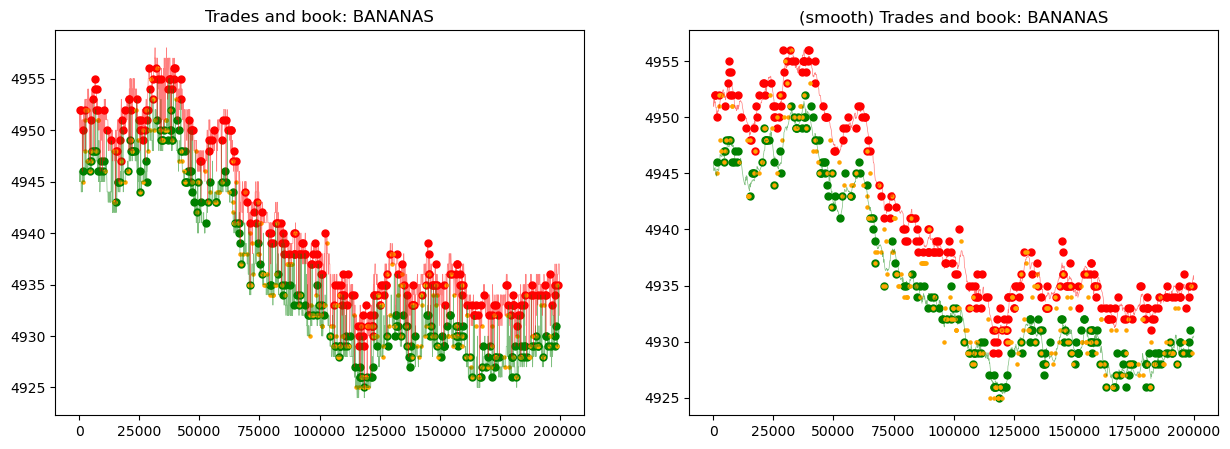

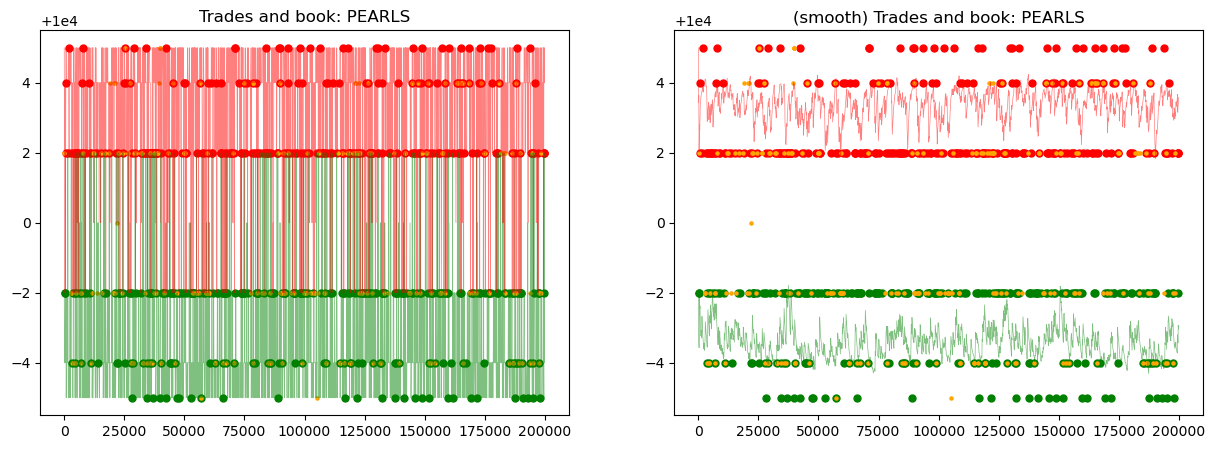

In [28]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    # show_mid=True,
)
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21,
    # show_mid=True,
)


### compare ref EMA to true EMA

In [52]:
ref_emas

,BANANAS,PEARLS,time
0,4949.00,10001.50,0
1,4948.86,10001.27,100
2,4948.79,10001.16,200
3,4948.76,10000.78,300
4,4948.78,10000.80,400
...,...,...,...
1990,4932.94,9999.94,199500
1991,4932.99,9999.95,199600
1992,4933.08,10000.22,199700
1993,4933.16,10000.20,199800


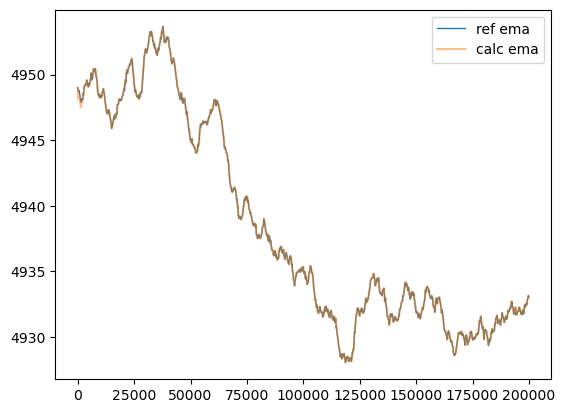

In [64]:
symbol = "BANANAS"

mids = book_tops[f"{symbol}_mid"]
ema = mids.ewm(span=21).mean()

plt.plot(ref_emas["time"], ref_emas["BANANAS"], label="ref ema", alpha=1, linewidth=1)
plt.plot(book_tops["time"], ema, label="calc ema", alpha=0.5)
plt.legend()

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4946.0,4952.0,4949.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4945.0,4950.0,4947.5,5.0,9996.0,10002.0,9999.0,6.0,100
2,4945.0,4951.0,4948.0,6.0,9996.0,10004.0,10000.0,8.0,200
3,4945.0,4952.0,4948.5,7.0,9996.0,9998.0,9997.0,2.0,300
4,4946.0,4952.0,4949.0,6.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
1991,4930.0,4937.0,4933.5,7.0,9996.0,9998.0,9997.0,2.0,199500
1992,4930.0,4937.0,4933.5,7.0,9995.0,10005.0,10000.0,10.0,199600
1993,4931.0,4937.0,4934.0,6.0,10002.0,10004.0,10003.0,2.0,199700


### PNL Graph

Text(0.5, 1.0, 'PNL (final = 5615.0)')

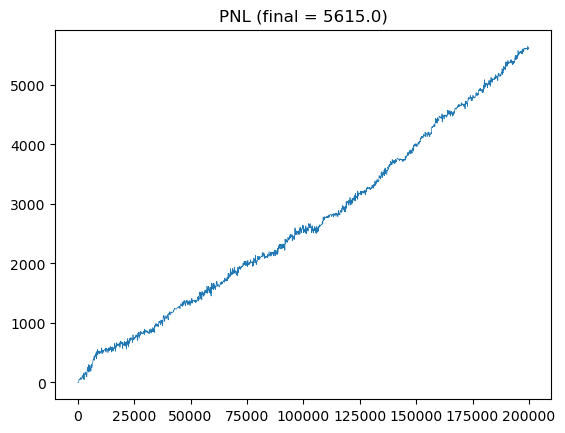

In [29]:
# pnl
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)
plt.title(f"PNL (final = {my_positions['pnl'].iloc[-1]})")


### Positions Graph

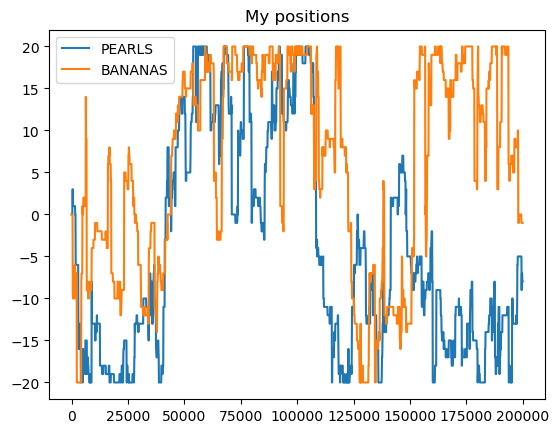

In [30]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

### Price movements (pct change)

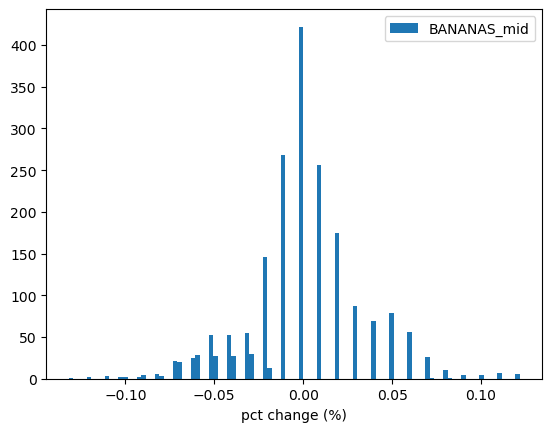

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1995.0,-0.000172,0.03403,-0.131739,-0.020205,0.0,0.020208,0.121766


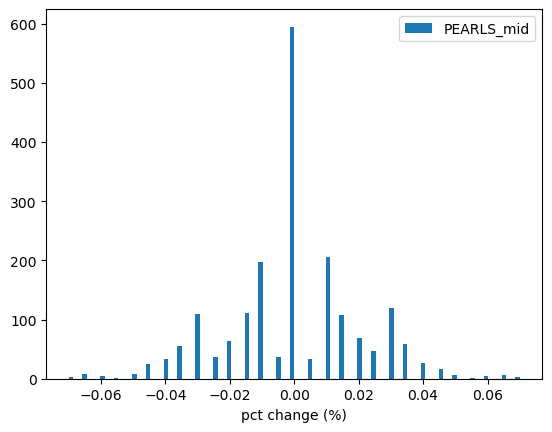

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,1995.0,0.000002,0.021166,-0.069976,-0.01,0.0,0.010001,0.070025


In [31]:
# distribution of price movements (pct change)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) / col).dropna()
    diffs = (diffs - 1) * 100
    plt.hist(diffs, bins=100, label=mid)
    plt.xlabel("pct change (%)")
    plt.legend()
    plt.show()
    display(diffs.describe().T)

### Price movements (actual change)

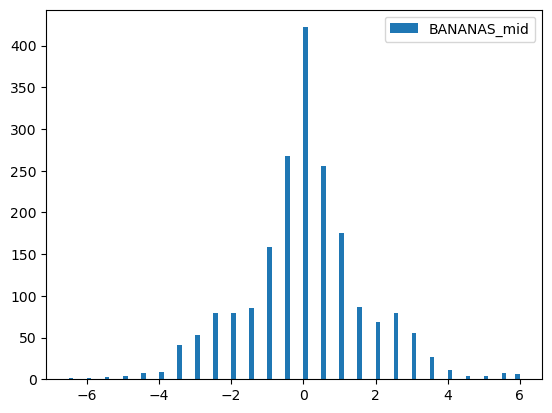

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1995.0,-0.008772,1.680482,-6.5,-1.0,0.0,1.0,6.0


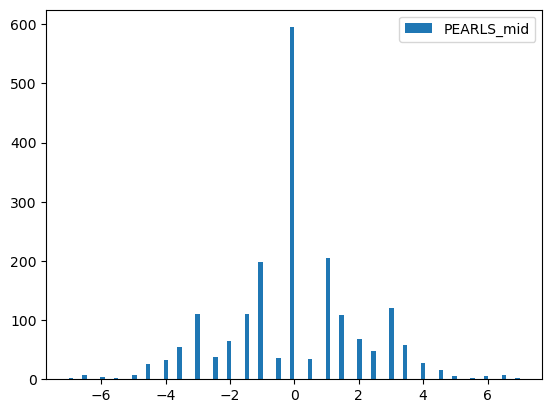

,count,mean,std,min,25%,50%,75%,max
PEARLS_mid,1995.0,0.0,2.116646,-7.0,-1.0,0.0,1.0,7.0


In [32]:
# distribution of price movements (actual #)
mids = ["BANANAS_mid", "PEARLS_mid"]

for mid in mids:
    col = book_tops[[mid]]
    diffs = (col.shift(-1) - col).dropna()
    plt.hist(diffs, bins=100, label=mid)
    plt.legend()
    plt.show()
    display(diffs.describe().T)


### Spread stats - BANANAS

In [33]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1996.0,5.307114,1.898785,1.0,5.0,6.0,7.0,7.0


### Spread stats - PEARLS

In [34]:
# spread summary stats

sym = "PEARLS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1996.0,6.819138,2.464963,2.0,6.0,8.0,8.0,10.0


In [35]:
# 
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,908.0,3.648678,3.820811,1.0,1.0,1.0,1.0,2.0,5.0,9.0,18.93,24.0


## Trade analysis - BANANAS

#### func - calc_rtns()

In [36]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



#### func - blur()

In [37]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

### Rtn over time

total prof 2697.5


,count,mean,std,min,25%,50%,75%,max
rtn_-1,424.0,1.022406,1.942761,-2.0,-0.5,-0.5,3.0,6.5
rtn_0,424.0,2.402123,1.560209,-3.0,1.5,2.5,3.5,7.5
rtn_1,424.0,2.476415,1.515300,-5.0,1.5,2.5,3.5,7.5
rtn_3,424.0,2.488208,1.689518,-5.0,1.5,2.5,3.5,8.0
rtn_10,424.0,2.607311,1.787048,-3.5,1.5,2.5,3.5,7.5
rtn_30,424.0,2.392689,2.271921,-3.5,1.0,2.5,4.0,8.5
rtn_100,424.0,2.385613,3.450324,-7.0,0.0,2.5,4.5,16.5


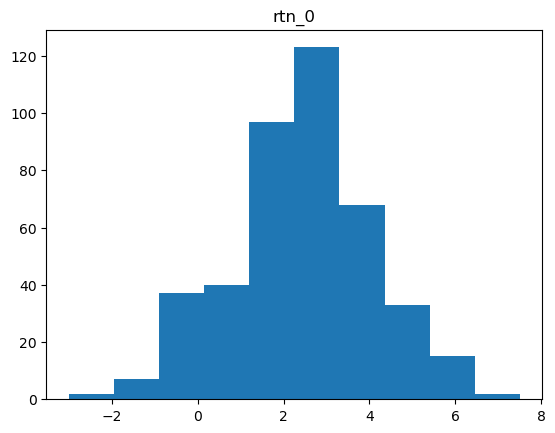

In [38]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])
plt.title("rtn_0")

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

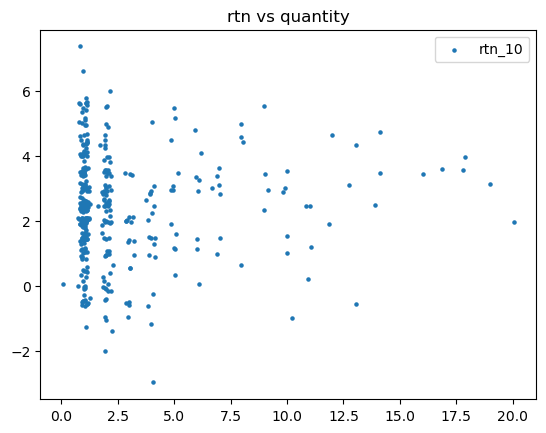

In [39]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### large trades

In [40]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
14,,4955.0,18,SUBMISSION,BANANAS,6600,6700,67,True,False,...,4944.5,10003.0,3.5,4.0,4.0,4.0,3.5,6.0,10.5,72.0
184,,4939.0,17,SUBMISSION,BANANAS,92400,92500,924,True,False,...,4936.0,10000.0,0.5,3.5,3.5,3.5,4.5,5.0,3.0,59.5
185,,4938.0,1,SUBMISSION,BANANAS,92400,92500,924,True,False,...,4936.0,10000.0,-0.5,2.5,2.5,2.5,3.5,4.0,2.0,2.5
188,,4938.0,1,SUBMISSION,BANANAS,94000,94100,940,True,False,...,4934.0,10000.0,-1.0,1.5,2.0,2.5,6.5,3.0,4.0,1.5
189,SUBMISSION,4933.0,18,,BANANAS,94000,94100,940,True,True,...,4934.0,10000.0,6.0,3.5,3.0,2.5,-1.5,2.0,1.0,63.0
323,SUBMISSION,4929.0,19,,BANANAS,151800,151900,1517,True,True,...,4930.0,10000.0,3.0,3.0,2.5,3.0,4.0,5.0,1.0,57.0
331,,4936.0,20,SUBMISSION,BANANAS,156700,156800,1566,True,False,...,4927.5,10000.0,3.0,2.0,2.5,3.0,3.5,2.5,8.5,40.0
407,,4934.0,16,SUBMISSION,BANANAS,188600,188700,1883,True,False,...,4934.0,10001.5,3.5,3.5,2.0,3.0,2.5,1.5,-0.0,56.0


### losers: trade/book graph

In [41]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

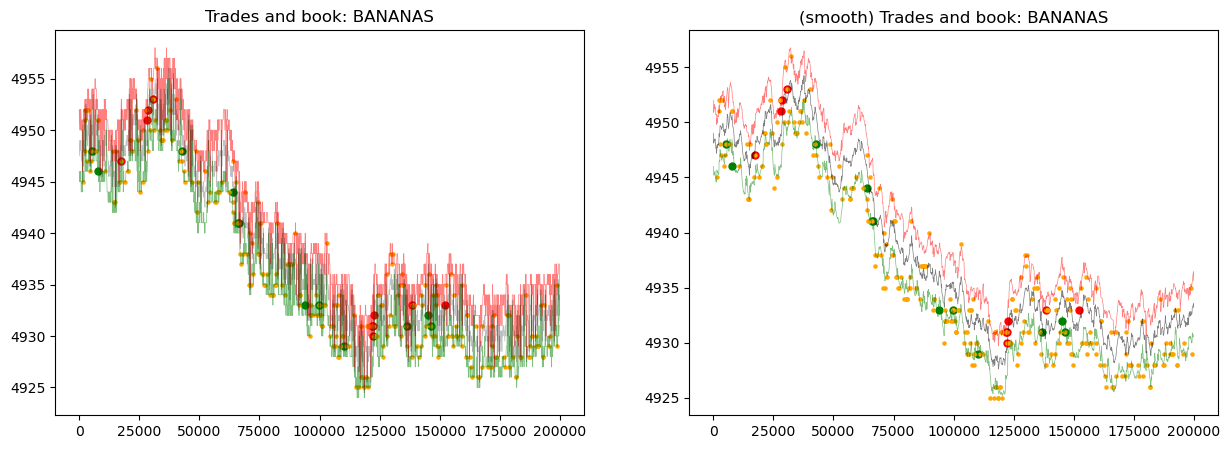

In [42]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=2e5, 
    span=10,
    show_mid=True,
)


In [43]:
losers

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
9,SUBMISSION,4948.0,2,,BANANAS,5100,5200,52,True,True,...,4948.0,9999.0,-0.5,2.0,2.5,2.5,-0.5,1.5,0.0,4.0
18,SUBMISSION,4946.0,2,,BANANAS,7600,7700,77,True,True,...,4948.0,10000.0,3.5,5.5,5.5,2.5,-0.5,3.0,2.0,11.0
34,,4947.0,2,SUBMISSION,BANANAS,17300,17400,174,True,False,...,4946.0,9999.0,1.0,-2.0,-5.0,-1.0,-1.5,-2.5,1.0,-4.0
59,,4951.0,1,SUBMISSION,BANANAS,28000,28100,280,True,False,...,4949.5,10000.0,2.5,2.5,2.0,2.0,-2.5,-2.0,1.5,2.5
61,,4952.0,1,SUBMISSION,BANANAS,28500,28600,285,True,False,...,4951.5,10003.5,-1.0,0.5,0.5,-0.5,-0.5,-3.0,0.5,0.5
65,,4953.0,3,SUBMISSION,BANANAS,30700,30800,307,True,False,...,4951.5,10000.0,-1.0,1.5,0.5,-0.0,-0.5,1.5,1.5,4.5
94,SUBMISSION,4948.0,3,,BANANAS,42500,42600,425,True,True,...,4944.0,9997.0,3.0,1.5,2.5,1.5,-0.5,3.5,-4.0,4.5
132,SUBMISSION,4944.0,1,,BANANAS,63700,63800,637,True,True,...,4941.0,10003.5,2.5,2.0,0.5,0.5,-1.0,-2.0,-3.0,2.0
137,SUBMISSION,4941.0,1,,BANANAS,66000,66100,660,True,True,...,4939.5,10000.0,3.0,2.5,2.5,1.5,-0.5,0.5,-1.5,2.5
138,SUBMISSION,4941.0,1,,BANANAS,66500,66600,665,True,True,...,4940.5,10000.0,-0.5,2.0,3.0,0.5,-0.5,-0.5,-0.5,2.0


## Trade analysis - PEARLS

### rtn over time

total prof 2905.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,517.0,0.844294,2.652049,-1.5,-1.0,-1.0,3.5,8.5
rtn_0,517.0,2.688588,1.914532,-1.5,2.0,2.0,4.0,8.0
rtn_1,517.0,2.775629,1.940976,-1.5,2.0,2.0,4.0,8.0
rtn_3,517.0,2.797872,1.749932,-1.5,2.0,2.0,4.0,8.5
rtn_10,517.0,2.733075,1.913925,-1.5,2.0,2.0,4.0,8.5
rtn_30,517.0,2.747582,1.784032,-1.5,2.0,2.0,4.0,8.5
rtn_100,517.0,2.714700,1.881503,-1.5,2.0,2.0,4.0,8.0


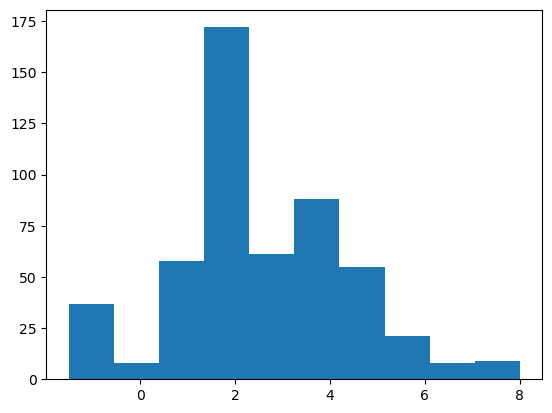

In [44]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

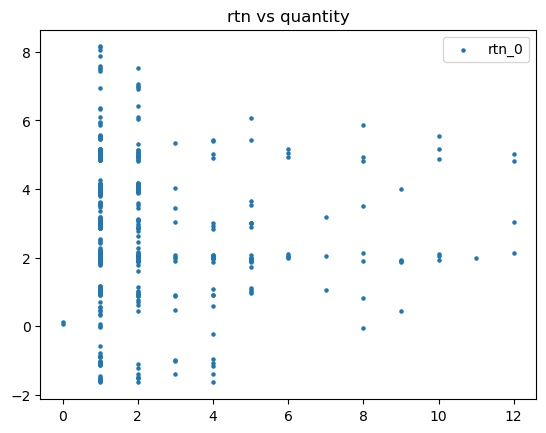

In [45]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### losers: rtn0 vs spread

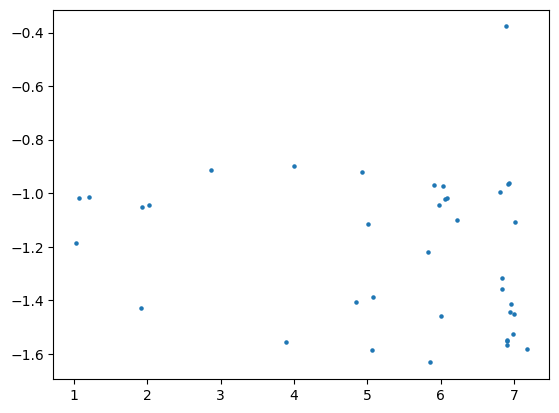

In [46]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["BANANAS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["BANANAS_spread"]), blur(df["rtn_0"]), s=5)

In [47]:
losers.describe().T

,count,mean,std,min,25%,50%,75%,max
price,38.0,9999.789474,2.015586,9998.0,9998.000,9998.00,10002.000,10002.0
quantity,38.0,1.736842,1.082645,1.0,1.000,1.00,2.000,4.0
order_time,38.0,88581.578947,48251.575273,22400.0,50950.000,74750.00,126200.000,189700.0
time,38.0,88681.578947,48251.575273,22500.0,51050.000,74850.00,126300.000,189800.0
turn,38.0,885.315789,481.787780,224.0,509.500,747.50,1261.000,1894.0
my_quantity,38.0,-0.157895,2.060259,-4.0,-1.000,1.00,1.000,4.0
BANANAS_-1,38.0,4940.197368,8.498441,4926.5,4933.500,4940.75,4947.125,4955.0
PEARLS_-1,38.0,9999.578947,3.087740,9996.5,9997.000,9997.00,10003.000,10003.5
BANANAS_0,38.0,4940.578947,8.367025,4927.0,4933.500,4940.25,4947.000,4955.0
PEARLS_0,38.0,9999.684211,3.249576,9996.5,9997.000,9997.00,10003.000,10003.5


### losers: histogram of price changes

(array([15., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

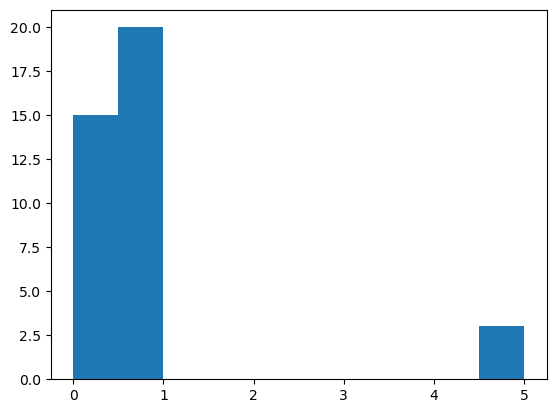

In [48]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

### losers: trade/book graph

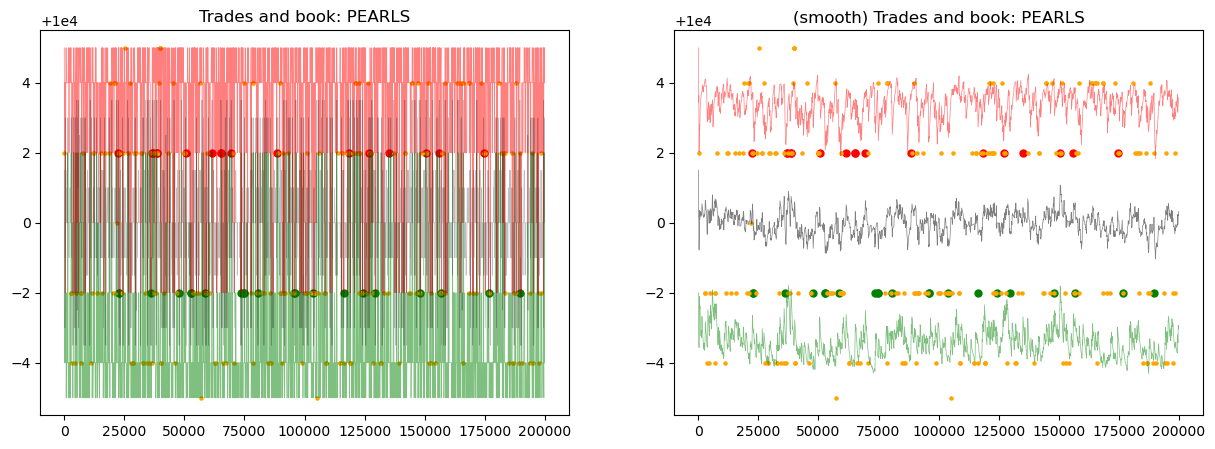

In [49]:
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=200000, 
    span=21,
    show_mid=True,
)
